In [12]:
### Library Imports

import pandas as pd
import numpy as np
import math 
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf 
import matplotlib.dates as mdates
from tabulate import tabulate

In [13]:
### Load in Stock Data

tickers = 'GOOG'
start_date = '2021-02-01'

def import_stock_data(tickers, start_date):
    data = pd.DataFrame()
    if len([tickers]) == 1:
        data[tickers] = yf.download(tickers, start_date)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = yf.download(tickers, start_date)['Adj Close']
    # Reset index to make headings in the same row
    data.reset_index(inplace = True)

    data['Date'] = pd.to_datetime(data['Date'])

    return data

stock_data = import_stock_data(tickers, start_date)
stock_data

[*********************100%%**********************]  1 of 1 completed


,Date,GOOG
0,2021-02-01,95.067497
1,2021-02-02,96.375504
2,2021-02-03,103.503502
3,2021-02-04,103.118500
4,2021-02-05,104.900002
...,...,...
766,2024-02-16,141.759995
767,2024-02-20,142.199997
768,2024-02-21,143.839996
769,2024-02-22,145.320007


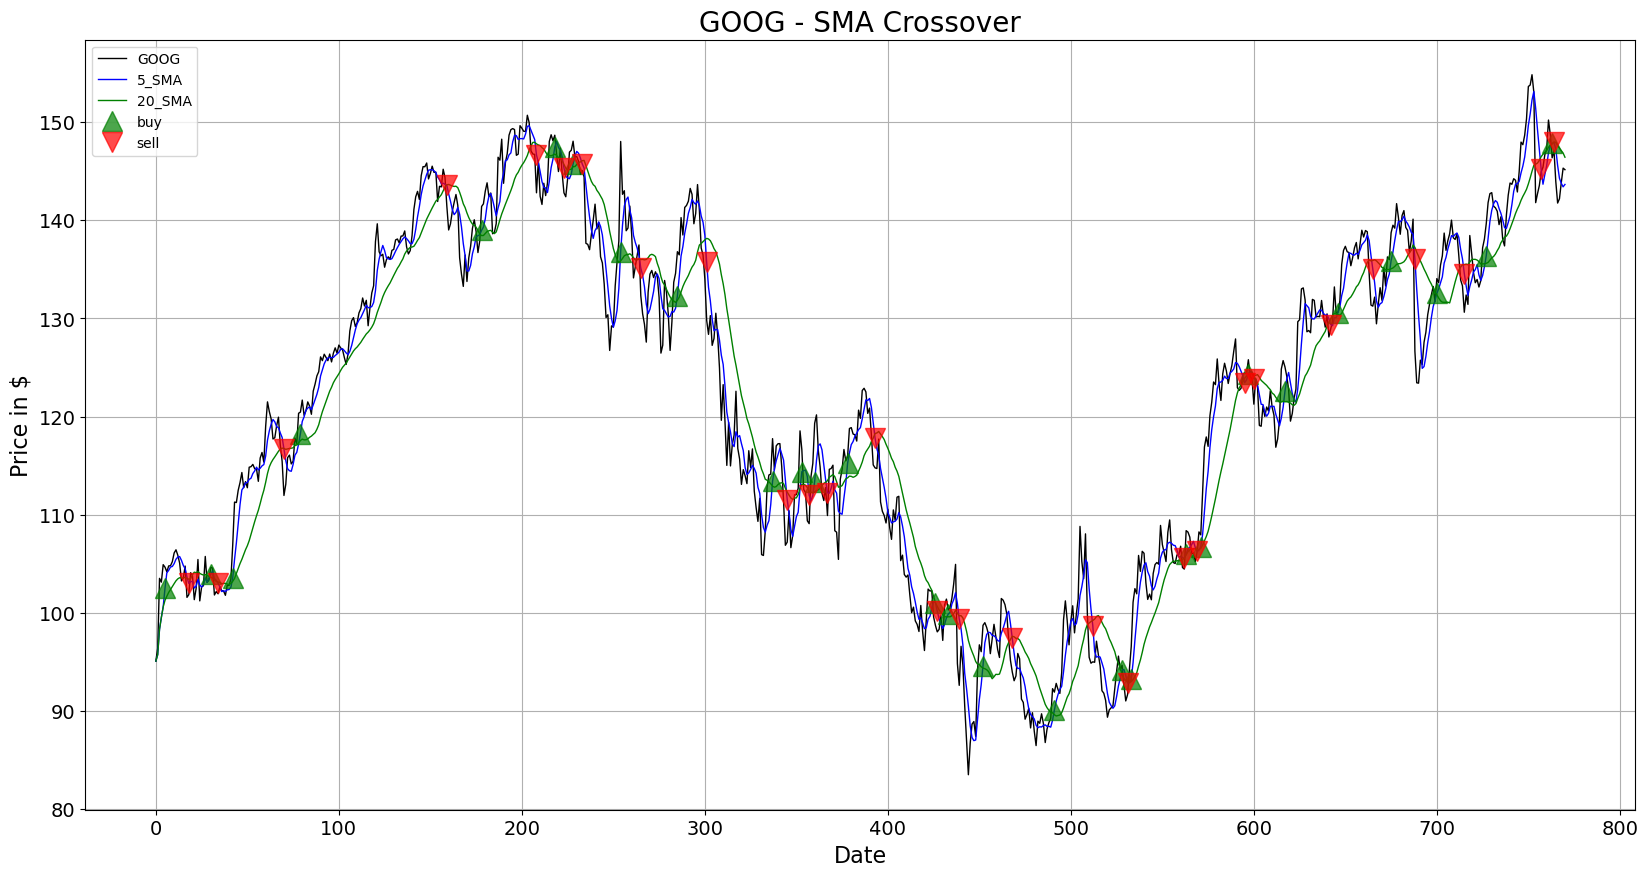

+-----+---------------------+---------+---------+----------+----------+----------+-----------+----------+------------+
|     | Date                |    GOOG |   5_SMA |   10_SMA |   20_SMA |   50_SMA |   100_SMA |   Signal | Position   |
|-----+---------------------+---------+---------+----------+----------+----------+-----------+----------+------------|
|   5 | 2021-02-08 00:00:00 | 104.646 | 102.509 |  101.268 | 101.268  | 101.268  |  101.268  |        1 | Buy        |
|  18 | 2021-02-26 00:00:00 | 101.843 | 102.991 |  104.359 | 103.418  | 103.418  |  103.418  |        0 | Sell       |
|  30 | 2021-03-16 00:00:00 | 104.626 | 103.907 |  103.26  | 103.638  | 103.4    |  103.4    |        1 | Buy        |
|  34 | 2021-03-22 00:00:00 | 101.929 | 103.016 |  103.263 | 103.132  | 103.31   |  103.31   |        0 | Sell       |
|  42 | 2021-04-01 00:00:00 | 106.887 | 103.534 |  102.888 | 103.203  | 103.271  |  103.271  |        1 | Buy        |
|  70 | 2021-05-12 00:00:00 | 111.954 | 116.695 

/var/folders/n5/bknqp6qs37l5l4bwv9wv3bs40000gn/T/ipykernel_58534/1831050385.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')


In [14]:
### Function to display SMA and EMA

def MovingAverageCrossStrategy(stock_data, window, short_window, long_window, moving_avg_type, display_table = True):
    '''
    The function accepts parameters such as the stock symbol, analysis duration, look-back periods, and the type of moving average 
    (SMA or EMA) to generate a Moving Average (MA) Crossover chart. Additionally, it provides buy/sell signals for the specified period
    '''
    # Parameters:
    # stock_data: (DataFrame) containing dates and closing prices
    # window: (array) specifying the moving average period, e.g., 5, 10, 20...
    # short_window: (int) specifying desired beginning window
    # long_window: (int) specifying desired ending window
    # moving_avg_type: (string) indicating the type of moving average to use ('SMA' or 'EMA')
    # display_table: (boolean) determining whether to display the date and price table at buy/sell positions (True/False)

    # Loop to compute rolling mean cols if SMA
    if moving_avg_type == 'SMA':
        for val in window:
            stock_data[f'{val}_SMA'] = stock_data['GOOG'].rolling(window = val, min_periods = 1).mean()

    # Loop to compute rolling mean cols if EMA
    if moving_avg_type == 'EMA':
        for val in window:
            stock_data[f'{val}_EMA'] = stock_data['GOOG'].ewm(span = val, adjust = False).mean()
    
    # Column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg_type
    long_window_col = str(long_window) + '_' + moving_avg_type  

    # Create a new column ‘Signal’ such that if short window SMA is greater than long window SMA then set Signal value as 1 
    # else when long window SMA is greater than short window SMA then set it’s value as 0
    stock_data['Signal'] = 0.0
    stock_data['Signal'] = np.where(stock_data[short_window_col] > stock_data[long_window_col], 1.0, 0.0)

    # Create a new column 'Position' which is a day-to-day difference of the 'Signal' column. 
    stock_data['Position'] = stock_data['Signal'].diff()


    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    stock_data['GOOG'].plot(color = 'k', lw = 1, label = 'GOOG')  
    stock_data[short_window_col].plot(color = 'b', lw = 1, label = short_window_col)
    stock_data[long_window_col].plot(color = 'g', lw = 1, label = long_window_col) 

    # plot 'buy' signals
    plt.plot(stock_data[stock_data['Position'] == 1].index, 
            stock_data[short_window_col][stock_data['Position'] == 1], 
            '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(stock_data[stock_data['Position'] == -1].index, 
            stock_data[short_window_col][stock_data['Position'] == -1], 
            'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    plt.ylabel('Price in $', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title('GOOG' + ' - ' + str(moving_avg_type) + ' Crossover', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

    if display_table == True:
        # If display_table is True, extract rows from stock_df where Position is 1 (Buy) or -1 (Sell)
        df_pos = stock_data[(stock_data['Position'] == 1) | (stock_data['Position'] == -1)]
        # Convert Position values to strings ('Buy' or 'Sell')
        df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
        # Print the resulting DataFrame in a tabular format using the tabulate function with specified headers and table format
        print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))


### Function Call
window = [5, 10, 20, 50, 100]
print(MovingAverageCrossStrategy(stock_data, window, short_window = 5, long_window = 20, moving_avg_type = 'SMA', display_table = True))